In [1]:
from codvidutils.utils import load_pictures, adding_images
from codvidutils.imageproc import map_categorical
import numpy as np
import pandas as pd
num_channels= 3
test_class = pd.read_csv('data/test_split_v5.csv', sep=' ')#, header=True)#, names=['patientID', 'image_path', 'class'])
X_test = load_pictures(test_class,"data/test/",channels = num_channels)

values_dict = {'COVID-19': 1,'pneumonia': 2,'normal': 0}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
diseaseID_test  = np.asarray(test_class["class_categorical"])
original_test = len(diseaseID_test)
print('shape X: {},  disease_ID (Y): {}'.format(X_test.shape[0],  diseaseID_test.shape[0] ))


shape X: 1525,  disease_ID (Y): 1525


In [2]:
print(test_class[test_class["class_categorical"]==0].shape)
print(test_class[test_class["class_categorical"]==1].shape)
print(test_class[test_class["class_categorical"]==2].shape)

(880, 3)
(59, 3)
(586, 3)


In [3]:
X_test, diseaseID_test = adding_images(X_test, diseaseID_test, strides=5 )
X_test = X_test / 255 
print('shape X: {},  disease_ID (Y): {}'.format(X_test.shape[0],  diseaseID_test.shape[0] ))
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0

shape X: 3000,  disease_ID (Y): 3000


In [4]:
val_class = pd.read_csv('data/validation_set.csv', sep=' ')#, header=True)#, names=['patientID', 'image_path', 'class'])
X_val = load_pictures(val_class,"data/test/",channels = num_channels)

val_class['class_categorical'] = val_class['class'].apply(map_categorical, args=(values_dict,))
diseaseID_val  = np.asarray(val_class["class_categorical"])
X_val = X_val[:,10:190,10:190,:]
X_val = X_val / 255

Y_val = np.copy(diseaseID_val)
Y_val[Y_val==2]=0

In [152]:
from tensorflow.keras.models import load_model
import tensorflow.keras

model = load_model("Inc2uncALL_ADD.hdf5")
p_val = model.predict(X_val)

In [ ]:
probs += [model.predict(X_test)]
probs += [model.predict(X_test)]

In [ ]:
probs = np.array(probs)
probs = np.reshape(probs,[14,3000])
probs.shape

In [6]:
del X_test, X_val
"""
Restart the kernel and don't run the cells with the model.

"""
probs = np.loadtxt("Inc2uncALL_ADD_14test.txt")
p_val = np.loadtxt("Inc2uncALL_ADD_val60.txt")

In [30]:
predictive_mean = np.mean(probs, axis=0)
predictive_variance = np.var(probs, axis=0)
print(np.mean(predictive_mean))
print(np.median(predictive_mean))


0.3842460218052839
0.2553977786696383


In [36]:
print(np.mean(Unce))
print(np.median(Unce))

0.09756048902208071
0.07328961837074685


In [32]:
from sklearn.metrics import mean_squared_error
e_2 = mean_squared_error(Y_val, p_val[:15])
print(e_2)

0.04328143059838674


In [39]:
Mean = predictive_mean 
Unce  = np.sqrt(predictive_variance+e_2)
print("******* MEAN values ******")
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

cm = confusion_matrix(Y_test, Mean.round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)
print("******* ORIGINAL images ******")
cm = confusion_matrix(Y_test[:original_test], Mean[:original_test].round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)

print("******* ADDED images ******")
cm = confusion_matrix(Y_test[original_test:], Mean[original_test:].round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)

******* MEAN values ******
[[1363  103]
 [ 513 1021]] 
 [[0.92974079 0.07025921]
 [0.33441982 0.66558018]]
******* ORIGINAL images ******
[[1363  103]
 [  23   36]] 
 [[0.92974079 0.07025921]
 [0.38983051 0.61016949]]
******* ADDED images ******
[[  0   0]
 [490 985]] 
 [[0.         0.        ]
 [0.33220339 0.66779661]]


In [10]:
cm = confusion_matrix(Y_test, Mean.round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)
print("Mean")
cm = confusion_matrix(Y_test[:original_test], Mean[:original_test].round())
print(cm)

print("Mean+ Unc")
cm = confusion_matrix(Y_test[:original_test], (Mean+Unce)[:original_test].round())
print(cm)

print("Mean- Unc")
cm = confusion_matrix(Y_test[:original_test], (Mean-Unce)[:original_test].round())
print(cm)

[[1363  103]
 [ 513 1021]] 
 [[0.92974079 0.07025921]
 [0.33441982 0.66558018]]
Mean
[[1363  103]
 [  23   36]]
Mean+ Unc
[[1212  254]
 [   9   50]]
Mean- Unc
[[1436   30]
 [  34   25]]


In [11]:
print(" Example values")
print("Normal people")
for p, u in zip(Mean[diseaseID_test==0][:5],Unce[diseaseID_test==0][:5]):
    print(p, "+/- ", u)
print("Neumonia")
for p, u in zip(Mean[diseaseID_test==2][:5],Unce[diseaseID_test==2][:5]):
    print(p, "+/- ", u)
print("COVID-19")
for p, u in zip(Mean[diseaseID_test==1][:5],Unce[diseaseID_test==1][:5]):
    print(p, "+/- ", u)

 Example values
Normal people
0.152753939053842 +/-  0.2181796984254221
0.048027815496815104 +/-  0.21023985232736042
0.4392763280442783 +/-  0.2616337810927393
0.29251833925289766 +/-  0.3198837094196652
0.053211220274014134 +/-  0.21811624145661615
Neumonia
0.02103836026591515 +/-  0.21139163786480375
0.01544683900803128 +/-  0.20857166010186584
0.4294019990733692 +/-  0.29218512312271216
0.12292819483471769 +/-  0.23676527850463955
0.009968219374838685 +/-  0.2082473056748665
COVID-19
0.016736002480164252 +/-  0.20976621127793285
0.0026337588420314467 +/-  0.20808329578851795
0.9132723978587559 +/-  0.22429682753612937
0.7341468312910625 +/-  0.3223049559963186
0.9866890779563359 +/-  0.20859133996708024


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

testScoreECM = 0
testScoreEAM = 0

for pred in probs:
    testScoreECM += mean_squared_error(Y_test, pred)
    testScoreEAM += mean_absolute_error(Y_test, pred)

testScoreECM = testScoreECM/len(probs)
testScoreEAM = testScoreEAM/len(probs)

varECM = 0
varEAM = 0

for pred in probs:
    varECM += (mean_squared_error(Y_test, pred)-testScoreECM)**2
    varEAM += (mean_absolute_error(Y_test, pred)-testScoreEAM)**2

varECM = (varECM/len(probs))**(0.5)
varEAM = (varEAM/len(probs))**(0.5)

print('Mean ECM: %.4f' % (testScoreECM))
print('Mean EAM: %.4f' % (testScoreEAM))
print('variance ECM: %.4f' % (varECM))
print('variance EAM: %.4f' % (varEAM))

In [12]:
def get_counts(mean, unce,nbins,):
    import numpy as np
    from scipy.stats import norm
    #mean = Pred[true_Y == label]
    #unce = Upre[true_Y == label]
    bins = np.linspace(0,1,nbins+1)
    bins[0] = -np.inf
    bins[-1] = np.inf
    probability = np.zeros([mean.shape[0], nbins])
    print(probability.shape)

    for i in range(mean.shape[0]):
        for j in range(nbins):
            probability[i,j] = (norm.cdf(bins[j+1],loc=mean[i],scale=unce[i])-norm.cdf(bins[j],loc=mean[i],scale=unce[i]))
    
    counts = np.sum(probability,axis = 0)
    variance = np.multiply(probability,(1- probability))
    variance = np.sum(variance,axis=0)
    uncounts = np.sqrt(variance)
    return counts, uncounts

In [13]:
def get_counts_by_class(Pred,Upre, true_Y, nbins):
    import numpy as np
    dic_counts = {0: [], 1:[],2:[] }
    dic_uncounts = {0: [], 1:[],2:[] }
    for label in np.unique(true_Y):
        print(label)
        dic_counts[label], dic_uncounts[label] = get_counts(Pred[true_Y==label],Upre[true_Y==label],nbins,)

    bins = np.linspace(0,1,nbins+1)
    bins += (bins[5]-bins[4])/2
    return dic_counts, dic_uncounts, bins[:-1]

In [14]:
dic_counts_3_e, dic_variance_3_e, bins = get_counts_by_class(Mean,Unce, diseaseID_test, nbins=30)
dic_counts_2_e, dic_variance_2_e, nbins = get_counts_by_class(Mean,Unce, Y_test, nbins=30)

0.0
(880, 30)
1.0
(1534, 30)
2.0
(586, 30)
0.0
(1466, 30)
1.0
(1534, 30)


In [15]:
np.sum(dic_counts_2_e[1])

1533.9999999999995

In [25]:
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelsize'] = 'large'
#mpl.rcParams['xtick.labelsize'] = 'XX-large'
#mpl.rcParams['ytick.labelsize'] = 'XX-large'
#mpl.rcParams['axes.labelsize'] = 'XX-large'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['font.size'] = '16'

In [26]:
def hist_with_unce (hist_bins, counts, uncer_counts, color1, color2,lw=2,alpha= 0.5 ,label = None, histtype = "step"):
    import matplotlib.pyplot as plt
    """
    hist_bins: array with the bin edges, (N+1)-array
    counts: N-array with the value of each bin
    uncer_counts: N-array with the uncertainty of each count.
    """
    plt.hist(hist_bins[:-1], hist_bins, weights = counts,histtype=histtype,color=color1,lw=lw,label =label)
    for i in range(counts.shape[0]):
        plt.fill_between(hist_bins[i:i+2], counts[i]-uncer_counts[i],counts[i]+uncer_counts[i], color=color2, alpha =alpha)


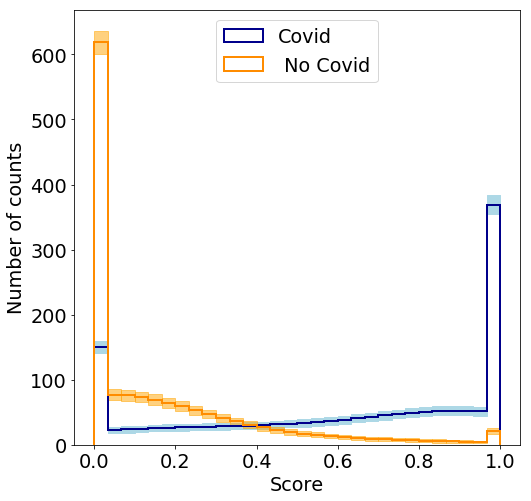

In [28]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
nbins = 30
bins = np.linspace(0,1,nbins+1)
lw = 2
hist_with_unce (bins,dic_counts_2_e[1], dic_variance_2_e[1], "darkblue", "lightblue",alpha=1 ,label = "Covid", histtype = "step")#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')
hist_with_unce (bins,dic_counts_2_e[0], dic_variance_2_e[0], "darkorange", "orange",alpha=0.5 ,label = " No Covid", histtype = "step")#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')


plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.savefig("histo2_sist_k.eps")
plt.legend(loc="upper center")
plt.show()

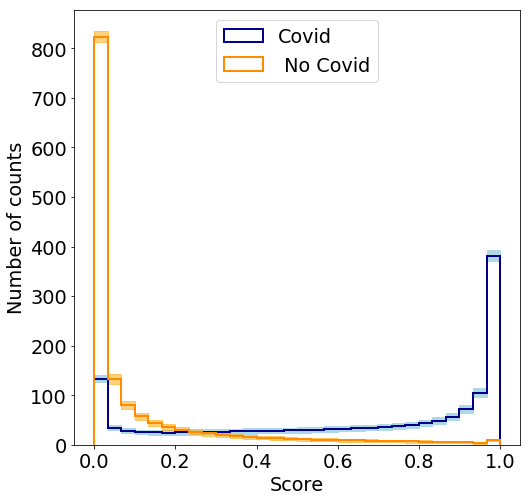

In [62]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
nbins = 30
bins = np.linspace(0,1,nbins+1)
lw = 2
hist_with_unce (bins,dic_counts_2[1], dic_variance_2[1], "darkblue", "lightblue",alpha=1 ,label = "Covid", histtype = "step")#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')
hist_with_unce (bins,dic_counts_2[0], dic_variance_2[0], "darkorange", "orange",alpha=0.5 ,label = " No Covid", histtype = "step")#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')


plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.savefig("histo2_nosist.eps")
plt.legend(loc="upper center")
plt.show()

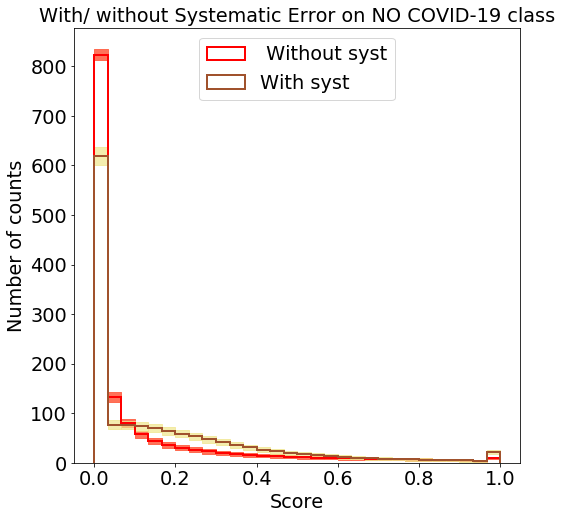

In [87]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
nbins = 30
bins = np.linspace(0,1,nbins+1)
lw = 2
hist_with_unce (bins,dic_counts_2[0], dic_variance_2[0], "red", "tomato",alpha=0.9 ,label = " Without syst", histtype = "step")#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')
hist_with_unce (bins,dic_counts_2_e[0], dic_variance_2_e[0], "sienna", "khaki",alpha=0.7 ,label = "With syst", histtype = "step")#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')

plt.title("With/ without Systematic Error on NO COVID-19 class")
plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.legend(loc="upper center")
plt.savefig("histo_nocovid_com.eps")
plt.show()

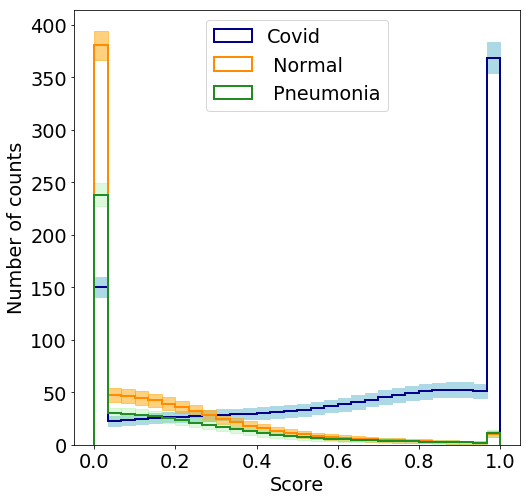

In [76]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
nbins = 30
bins = np.linspace(0,1,nbins+1)
lw = 2
hist_with_unce (bins,dic_counts_3_e[1], dic_variance_3_e[1], "darkblue", "lightblue",alpha=1 ,label = "Covid", histtype = "step")#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')
hist_with_unce (bins,dic_counts_3_e[0], dic_variance_3_e[0], "darkorange", "orange",alpha=0.5 ,label = " Normal", histtype = "step")#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')
hist_with_unce (bins,dic_counts_3_e[2], dic_variance_3_e[2], "forestgreen", "lightgreen",alpha=0.3 ,label = " Pneumonia", histtype = "step")#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')


plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.legend(loc="upper center")
plt.savefig("histo3_sist.eps")
plt.show()

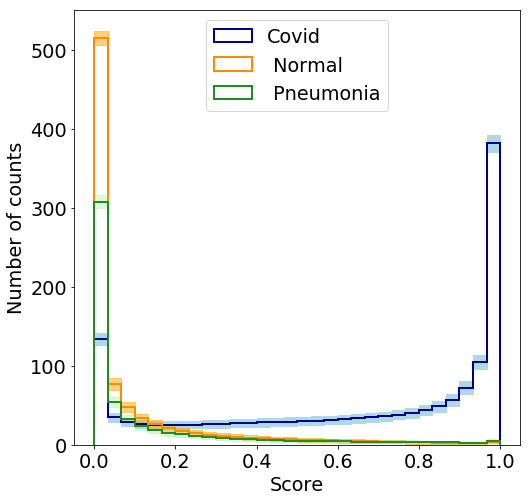

In [61]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
nbins = 30
bins = np.linspace(0,1,nbins+1)
lw = 2
hist_with_unce (bins,dic_counts_3[1], dic_variance_3[1], "darkblue", "lightblue",alpha=1 ,label = "Covid", histtype = "step")#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')
hist_with_unce (bins,dic_counts_3[0], dic_variance_3[0], "darkorange", "orange",alpha=0.5 ,label = " Normal", histtype = "step")#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')
hist_with_unce (bins,dic_counts_3[2], dic_variance_3[2], "forestgreen", "lightgreen",alpha=0.3 ,label = " Pneumonia", histtype = "step")#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')


plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.legend(loc="upper center")
plt.savefig("histo3_nosist.eps")
plt.show()

In [40]:
Upper = Mean + Unce
Upper[Upper>1] = 1
Upper[Upper<0] = 0
Lower = Mean - Unce
Lower[Lower>1] = 1
Lower[Lower<0] = 0

In [41]:
from sklearn.metrics import roc_curve , auc
fpr, tpr, thresholds = roc_curve(Y_test, Mean)
fpr_U, tpr_U, thr = roc_curve(Y_test,Upper)
fpr_L, tpr_L, thr = roc_curve(Y_test,Lower)
roc_auc = auc(fpr,tpr)
roc_auc_U = auc(fpr_U,tpr_U)
roc_auc_L = auc(fpr_L,tpr_L)
print(roc_auc, roc_auc_L, roc_auc_U)

0.9053366974321029 0.8582080393304294 0.9030468542949177


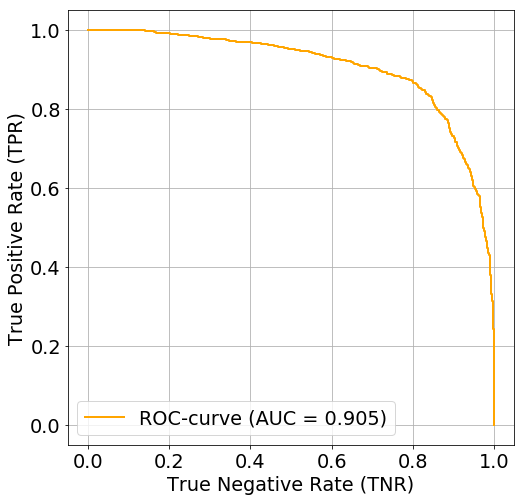

In [60]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
plt.grid(True)
lw = 2
plt.plot(1-fpr, tpr, color='orange',lw=2, label='ROC-curve (AUC = %0.3f)' % (roc_auc))


plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('True Negative Rate (TNR)')

plt.legend(loc="lower left")
plt.savefig("roc_curve_covid.eps")
plt.show()

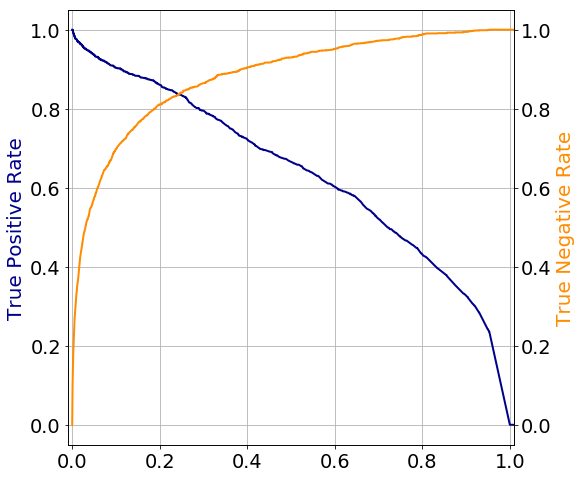

In [57]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
plt.grid(True)
lw = 2
ax.plot(thresholds, tpr, color='darkblue',lw=2)
ax.set_ylabel("True Positive Rate",color="darkblue",fontsize=20)

ax2=ax.twinx()
ax2.plot(thresholds, 1-fpr, color='darkorange',lw=2)

ax2.set_ylabel("True Negative Rate",color="darkorange",fontsize=20)
plt.xlim([-0.01,1.01])
#plt.ylabel('True Positie Rate (TPR)')
plt.xlabel('Thresholds')

plt.savefig("rates_curve_covid.eps")
plt.show()

In [103]:
for thr in np.arange(thresholds[(tpr>0.83) & ((1-fpr)>0.83)].shape[0]):
    print(thresholds[(tpr>0.83) & ((1-fpr)>0.83)][thr], "tpr :", tpr[(tpr>0.83) & ((1-fpr)>0.83)][thr], ", 1-fpr:" ,(1-fpr)[(tpr>0.83) & ((1-fpr)>0.83)][thr])

0.2575554621538946 tpr : 0.8305084745762712 , 1-fpr: 0.8465211459754434
0.25634965606565985 tpr : 0.8305084745762712 , 1-fpr: 0.8458390177353342
0.25366172567009926 tpr : 0.8318122555410691 , 1-fpr: 0.8458390177353342
0.2531272401767118 tpr : 0.8318122555410691 , 1-fpr: 0.8431105047748977
0.2530439158103296 tpr : 0.8324641460234681 , 1-fpr: 0.8431105047748977
0.2527313618255513 tpr : 0.8324641460234681 , 1-fpr: 0.8410641200545703
0.24800648653347576 tpr : 0.8350717079530638 , 1-fpr: 0.8410641200545703
0.24789529559867723 tpr : 0.8350717079530638 , 1-fpr: 0.8403819918144612
0.24719608641628707 tpr : 0.8357235984354628 , 1-fpr: 0.8403819918144612
0.24600879661738873 tpr : 0.8357235984354628 , 1-fpr: 0.8376534788540245
0.2436863754742912 tpr : 0.8363754889178618 , 1-fpr: 0.8376534788540245
0.24343039719055273 tpr : 0.8363754889178618 , 1-fpr: 0.8369713506139154
0.24303788079747132 tpr : 0.8370273794002607 , 1-fpr: 0.8369713506139154
0.24088323249348573 tpr : 0.8370273794002607 , 1-fpr: 0.

In [90]:
print(thresholds[(tpr>0.835) & ((1-fpr)>0.835)])#& (thresholds>0.2) & (thresholds<0.3)])

[0.24800649 0.2478953  0.24719609 0.2460088  0.24368638 0.2434304
 0.24303788]


In [107]:
print((1-fpr)[(thresholds>0.24) & (thresholds<0.25) ])
print("*********")
print(tpr[(thresholds>0.24) & (thresholds<0.25) ])
print(thresholds[(thresholds>0.24) & (thresholds<0.25) ][-3])

[0.84106412 0.84038199 0.84038199 0.83765348 0.83765348 0.83697135
 0.83697135 0.83356071]
*********
[0.83507171 0.83507171 0.8357236  0.8357236  0.83637549 0.83637549
 0.83702738 0.83702738]
0.24343039719055273


In [120]:
a  = thresholds[(thresholds>0.24) & (thresholds<0.25) ][-3]
s = (len(Mean[(Mean>= a) & (Y_test==1)])/len(Y_test[(Y_test==1)]))

su = (len(Y_test[((Mean+Unce)>= a) & (Y_test==1)])/len(Y_test[(Y_test==1)]))
sl = (len(Y_test[((Mean-Unce)>= a) & (Y_test==1)])/len(Y_test[(Y_test==1)]))
print(s, su-s, s-sl)

0.8363754889178618 0.11473272490221642 0.20013037809647982


In [122]:
s = (len(Mean[(Mean<= a) & (Y_test==0)])/len(Y_test[(Y_test==0)]))

su = (len(Y_test[((Mean+Unce)<= a) & (Y_test==0)])/len(Y_test[(Y_test==0)]))
sl = (len(Y_test[((Mean-Unce)<= a) & (Y_test==0)])/len(Y_test[(Y_test==0)]))
print(s, su, sl)
print(s, su-s, s-sl)

0.8376534788540245 0.5088676671214188 0.9427012278308322
0.8376534788540245 -0.3287858117326057 -0.10504774897680769
